In [1]:
import cdpm
from cdpm import CondDirichletProcessMix
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from bayesiankalman import mcmc
from tqdm import tqdm
import pandas as pd

In [2]:
%matplotlib inline
plt.style.use(['seaborn-dark-palette', 'seaborn-poster'])

In [3]:
time_dim = 1000
sigma = 0.1
mu = 0.0
#rho = 0.5

In [4]:
np.random.seed(1230)

In [5]:
# initial period

alpha_series = []
alpha_series.append(0.0)  # initial alpha value is 0.0

In [6]:
cl_idx = 0 
for time_idx in tqdm(range(time_dim)):
    if (alpha_series[time_idx] >= -0.1 and alpha_series[time_idx] <= 0.1):
        rho = np.random.normal(0.8, sigma, 1)[0]
    #    alpha = mu + rho*(alpha_series[time_idx]-mu) + np.random.normal(0,sigma,1)[0]
    else:
        rho = np.random.normal(0.1, sigma, 1)[0]
        
    alpha = mu + rho*(alpha_series[time_idx]-mu) + np.random.normal(0,sigma,1)[0]
    
    alpha_series.append(alpha)

100%|██████████| 1000/1000 [00:00<00:00, 165573.35it/s]


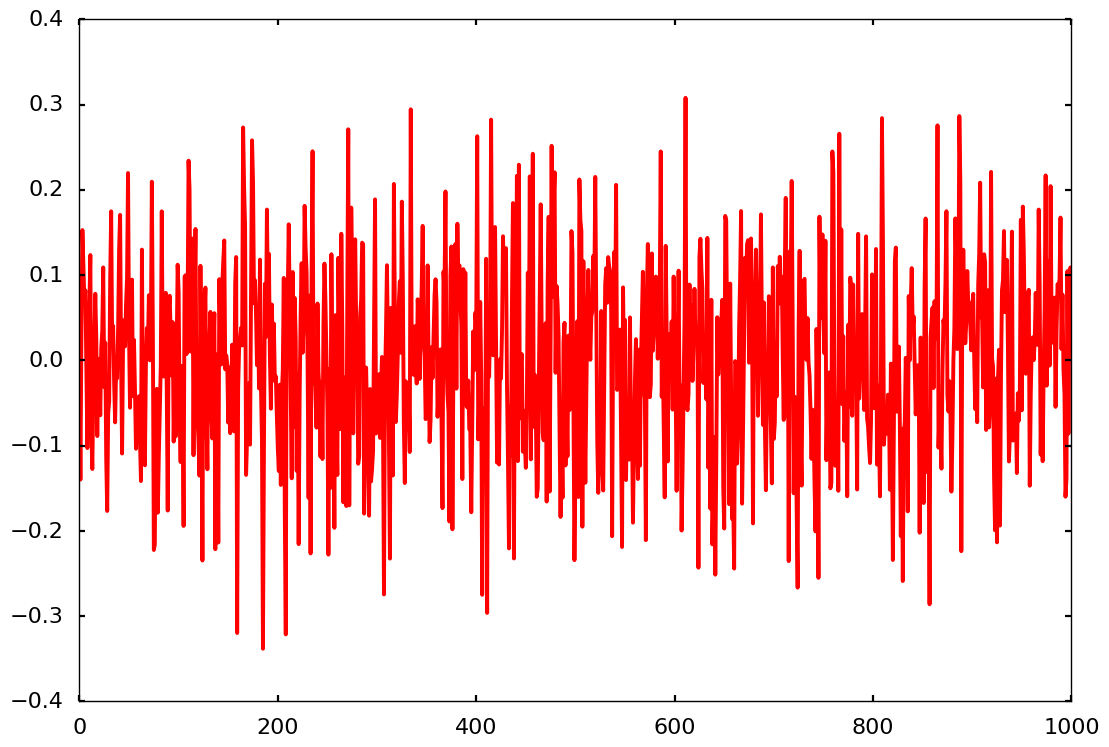

In [7]:
alpha_series_fig, alpha_series_ax = plt.subplots(1,1)
alpha_series_ax.plot(alpha_series, c='red')

## Estimation

In [8]:
stick_scale = 1
beta_mu, beta_sigma = 0, 0.5 # mean and standard deviation
sigma_df, sigma_scale = 2, 1

In [9]:
#cluster_series, alpha_series, beta_mat, sigma_mat = cdpm.simulate_cdpm(time_dim, beta_mu, beta_sigma, stick_scale)

In [10]:
prior = {
    'comp': {
        'coeff': {'mean': [beta_mu], 'cov': [beta_sigma]},
        'precn': {'scale': [sigma_scale**(-1)], 'shape': [sigma_df]}
    },
    'sticks': {
        'params': {
            'c': [stick_scale]
        }
    }
}

In [11]:
mean_precn = np.asarray(sigma_scale**(-1) / (sigma_df - 1))

In [12]:
## Initialization
model = CondDirichletProcessMix(beta_mu, tau=mean_precn,regressor=alpha_series[:-1], regressand=alpha_series[1:])

In [13]:
num_draws = 3000

In [14]:
cluster_identity_draws = np.empty((num_draws, time_dim))
stick_draws = np.full((num_draws, 30),np.nan)
beta_draws = np.full((num_draws, 30),np.nan)
precision_draws = np.full((num_draws, 30),np.nan)

In [15]:
for draw_idx in tqdm(range(num_draws)):
    model_posterior = model(prior)
    cluster_identity_draws[draw_idx] = model_posterior[0]
    stick_draws[draw_idx,:len(model_posterior[1])] = model_posterior[1]
    beta_draws[draw_idx,:len(model_posterior[2])] = np.squeeze(model_posterior[2]) 
    precision_draws[draw_idx,:len(model_posterior[3])] = model_posterior[3]
    

100%|██████████| 3000/3000 [00:11<00:00, 260.26it/s]


## Get the dynamics

In [16]:
percentiles = (1, 5, 25, 50, 75, 95, 99)

In [17]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

In [18]:
beta_est = np.array(pd.DataFrame(beta_draws).mean().dropna())
sigma_est = 1/ np.array(pd.DataFrame(precision_draws).mean().dropna())

In [19]:
alpha_est_mat = np.empty((time_dim+1, num_draws))
alpha_est_mat[0] = np.zeros(num_draws)

In [20]:
for t_idx in tqdm(range(time_dim)):
    cl_idx = cluster_identity_draws[:,t_idx].astype(int)
    alpha_f = np.multiply(beta_est[cl_idx],alpha_est_mat[t_idx]) + np.multiply(np.sqrt(sigma_est[cl_idx]), np.random.normal(0,1,num_draws))
    alpha_est_mat[t_idx+1] = alpha_f

100%|██████████| 1000/1000 [00:00<00:00, 6196.43it/s]


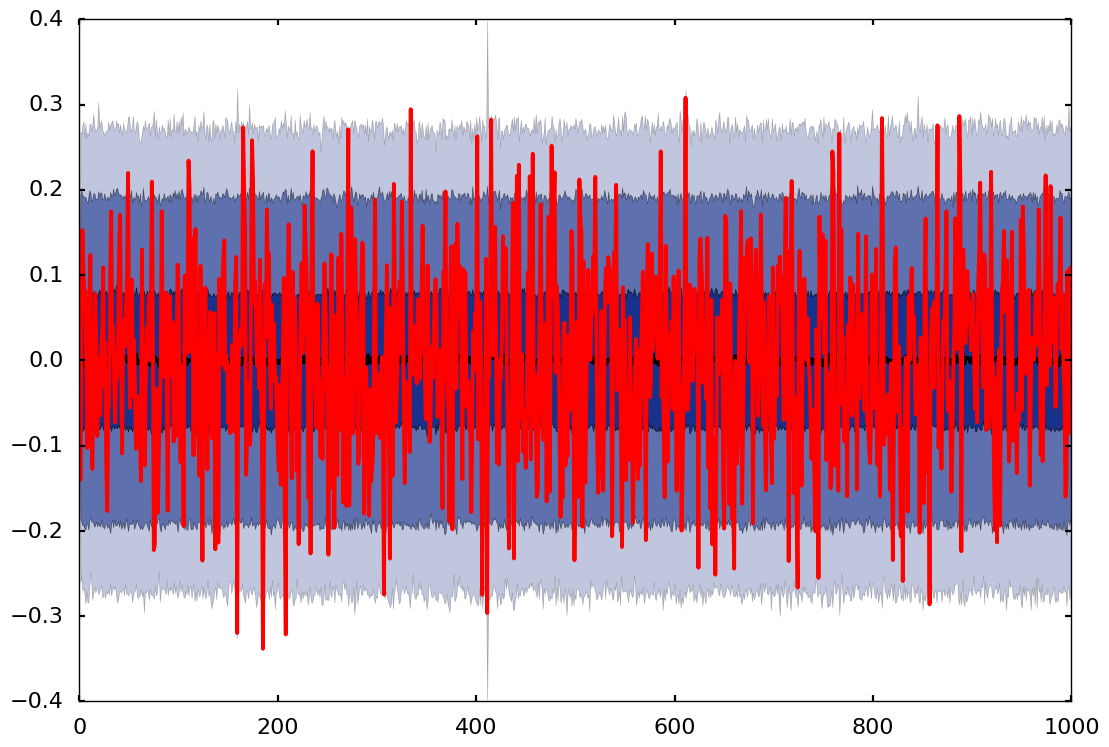

In [21]:
alpha_comparison_fig, alpha_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(alpha_comparison_ax, pd.DataFrame(alpha_est_mat), percentiles, c='black')
alpha_comparison_ax.plot(alpha_series, c='red')